# Self-Driving Car Engineer Nanodegree


+# Project: **Build a Traffic Sign Recognition Classifier**
### Adam Tetelman

In this project I used the tools that were taught througout the "Introduction to Neural Networks," "MiniFlow," "Introduction to TensorFlow,"  "Deep Neural Networks," and "Convolutional Neural Network" lessons.

The project relies on the following packages:
 - python3
   - numpy (for data/array manipulation)
   - sklearn (for data pre-processing)
   - tensorflow (for deep learning)
   - jupyter (for this notebook)
   - matplotlib (for data exploration)
   - cv2 (for image processing - opencv2)  
   
The tools taught included:
  - Data Normalization
  - Neural Networks 
  - Convolutional Neural Networks
  - LeNet-5
  - Tensorflow NN implementation

The resources used included:
  - GTSRB training image dataset (downloaded in-line below)
  - A small collection of German street signs (located in ./datasets)


This project is broken down into 5 steps. 

Step 0 deals with downloading and parsing the data. During this phase I defined several helper functions to download, parse, etc. I download around 250MB of training data, convert it to numpy arrays, split it into a train, validation, and test set, and serialize it to a few pickle files.

Step 1 deals with exploring the dataset. During this phase I defined several helper functions to analyze and process the data. I process the data a bit, print some basic meta-data about the data, and plot a few stats about the training set. 

Step 2 deals with defining and training a model.  During this phase I defined several helper functions to evaluate, train, and predict. I also defined several helper tensors. I then define a  model based on the Convolution Neural Network (LeNet) demonstrated in previous labs. This section ends with a training segment that took roughly 400 minutes to run for 4000 Epochs on my Nvidia GTX 960M GPU.

Step 3 deals with testing the accuracy of that model. During this phase I calculated the accuracy on my train, validation, and test data. I imported several new test images from the Internet and scored/analyzed my acccuracy on that dataset. 

Lastly, step 4 is an optional exploratory stage looking into the learned features of the model. During this phase I define a few helper functions to print the activation of a convolutional layer of my network. I run several stimuli images through these functions and discuss what the output says about the learned features of my model.

Overall the results looked fairly good. I was able to perform with ~95 accuracy on my test set which was 10% of the overall dataset. I was only able to achieve ~80% accuracy over the new data and that drop in accuracy seemed in large part to pictures taken at odd angles, with too much cropping, or with odd coloring. I believe there may be some room for improvement in the pre-processing given the results of these new images. It is also likely that the model has overfit to the dataset a bit, and that re-training with a larger test set may yield more generalizable results.

In [1]:
# Data exploration
import matplotlib.pyplot as plt
%matplotlib inline

# File manipulation/retrieval
import os
import pickle
from zipfile import ZipFile
from urllib.request import urlretrieve
from hashlib import md5
from tqdm import tqdm
import random
import csv

# Image processing
import cv2
from PIL import Image
import matplotlib.image as mpimg

# Machine Learning
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from time import time

## Step 0: Download & Convert Dataset

The first step in this project will be to download the publicly available training dataset from the Internet, do some initial image resizing, convert the images to an array Tensorflow can work with, and save the data for later use.

### Helper Functions

I first define a few helper functions for downloading, validating, and unpackaging the dataset.

In [2]:
def get_sign_map(file):
    '''Parse a csv containing mapping from sign id to sign name, return dict'''
    signs = {}
    signs[-1] = "Unknown sign." # Add a label for unidentified 
    with open(file, 'r') as f:
        reader = csv.reader(f)
        next(reader, None) # Skip header
        for row in reader:
            signs[int(row[0])] = row[1]
    return signs
            

def download(url, file):
    '''
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    '''
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')    

        
def open_and_resize_image(image_file, img_resize):
    '''Helper function to ensure we open, resize, and convert images consistently
    Specify img_resize=None to skip resizing and downscaling (useful for displaying original image)
    '''
    image = Image.open(image_file)
    
    # The images in the dataset vary from 15x15 to 250x250 px
    # In order to make processing easier down the road we resize everything
    # In order to further lighten the memory constraints we downscale the image to dtype=float32
    if img_resize is not None:
        image = image.resize(img_resize)
        image = np.array(image, dtype=np.float32)
        
    # Return a numpy array of the image
    return np.array(image)


def uncompress_features_labels(file, img_resize):
    '''
    Uncompress features and labels from a zip file
    
    Files should be stored such that all images are in a 
    directory pertaining to their category under the falling
    folder stucture:
        GTSRB/Final_Training/Images/<directory>/<image_name>.ppm
        
    Images will be resized to the dimensions of <img_resize>
    
    :param file: The zip file to extract the data from
    :param img_resize: A tuple used to define the new image sizes
    '''
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Verify the file is a ppm imagefile
            if filename.endswith(".ppm"):
                with zipf.open(filename) as image_file:
                    feature = open_and_resize_image(image_file, img_resize)

                # Get the category from the folder structure
                # We know this is a zero-padded int, so we cast it for easier parsing later
                label = int(os.path.split(os.path.split(filename)[0])[1])

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)


def pickle_it(pickle_file, pickle_map):
    '''Given a file destination and a map pickle the map to the file destination.
    If the file already exists, immediately return.
    :param pickle_file: The destination pickle file
    :param pickle_map: the Python dict to be pickled
    '''
    if os.path.isfile(pickle_file):
        print('Pickle file already exists at %s' %(pickle_file))
    else:
        print('Saving data to pickle file %s...' %(pickle_file))
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(pickle_map,
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

### Download & Validate data
I create a data directory, download the zip file, and verify the md5 matches.

#### Set Data Parameters
Before doing any download work I set the data directory, data url, download path, md5, new image size, and pickle file destinations.

In [3]:
# Set and create the data directory
data_dir = os.path.join("datasets","gtsrb")

# Set the url and file names as well as a checksum
data_url = 'http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip'
data_zip_file = os.path.join(data_dir, 'GTSRB_Final_Training_Images.zip')
data_md5 = 'f33fd80ac59bff73c82d25ab499e03a3'

# Sign mapping file
sign_map_file = "signnames.csv"

# Save all our data to files containing everything, only train, only cv, and only test
full_data_file = os.path.join(data_dir, "gtsrb_full_data.pickle")
train_file = os.path.join(data_dir, "gtsrb_training_data.pickle")
cv_file = os.path.join(data_dir, "gtsrb_validation_data.pickle")
test_file = os.path.join(data_dir, "gtsrb_testing_data.pickle")

In [4]:
# Get the features and labels from the zip files
img_resize = (32, 32) #Pick 32x32 to match LeNet and reduce memory needs

#### Download Data
This is the point where I actually downloaded and verified the external files. If the file has already been downloaded the download function will immediatelly return, so there is no harm in running this cell multiple times.

In [5]:
# Create the data directory
os.makedirs(data_dir, exist_ok=True)

# Download the data file locally
download(data_url, data_zip_file)

# Verify the file is correct
assert md5(open(data_zip_file, 'rb').read()).hexdigest() == data_md5, \
'Downloaded training zip file is corrupted.  Remove the file at %s and try again.' %(data_zip_file)

print("Training data successfully downloaded.")

Training data successfully downloaded.


### Extract & Resize Images

Rather then manually extracting the zip file this section of code will open the downloaded training set and iterate over all of the images in the training set. During this process the images will be resied to the dimensions in the *img_resize* tuple. The image and corresponding image class are stored in features, labels respectively.

The images in the dataset range from 15x15 pixels to 250x250 pixels. In order to save on some memory, make pipeline processing easier down the road, and to generalize the dataset, I have chosen to resize all of the images at this point in the process.

In [6]:
features, labels = uncompress_features_labels(data_zip_file, img_resize)
print("Images and labels successfully parsed and resized to %s." %(str(img_resize)))

100%|███████████████████████████████████████████████████████████████████████| 39299/39299 [00:38<00:00, 1012.83files/s]


Images and labels successfully parsed and resized to (32, 32).


#### Split Data Into Train, Test, and Validation

I now split the data into three datasets. I first define how large each dataset should be (a percentage of total data), and then use sklearn to randomly split the data. Lastly I have a verification cell as a quick sanity check.

I use two seed values for the split to make result reproduction easier.

In [7]:
# Set seed values to make data shuffling repeatable
seed1 = 4453
seed2 = 6843

# Specify the percentage of the data to be used as cross_validation data and test data
# The remainding percentage is used as train data
test_percentage = .1 # Used for predicting how well the model will generalize
cv_percentage = .3 # Used for choosing parameter

In [8]:
# Split the Training data out from all data, save the remainding in tmp variables
train_features, tmp_features, train_labels, tmp_labels = train_test_split(features, labels,
        test_size = (test_percentage + cv_percentage), random_state = seed1)

# Split the CV and Test data out from the remaining data stored in the tmp variables
cv_features, test_features, cv_labels, test_labels = train_test_split(tmp_features, tmp_labels,
        test_size = (test_percentage/(cv_percentage + test_percentage)), random_state = seed2)

In [9]:
# Verify that we properly split the labels alongside the features
assert train_features.shape[0] == train_labels.shape[0]
assert cv_features.shape[0] == cv_labels.shape[0]
assert test_features.shape[0] == test_labels.shape[0]

# Print the size of our 3 datasets
print("Training data and labels have the following shape: %s" %(str(train_features.shape)))
print("Cross Validation data and labels have the following shape: %s" %(str(cv_features.shape)))
print("Testing data and labels have the following shape: %s" %(str(test_features.shape)))

Training data and labels have the following shape: (23525, 32, 32, 3)
Cross Validation data and labels have the following shape: (11763, 32, 32, 3)
Testing data and labels have the following shape: (3921, 32, 32, 3)


#### Save, Restore, and Validate Data
The last step in the Download/Validate process it to take the data and serialize it to disk and create some functions so that it can be read back later. The last block of code in this section simply verifies that the loaded code is as expected.


I have chosen to do this using Pickle and I have defined a datafile containing only each dataset, and a forth containing all data.
  - 'train_features', 'cv_features', 'test_features': A (?, 32, 32, 3) numpy array containing  float32 images
    - (32, 32) comes from img_resize.
    - ? comes from the number of images
  - 'train_labels', 'cv_labels', 'test_labels': A (?, 1) numpy array containing int values
    - ? comes from the number of images

The original dataset also includes 'coords' and 'sizes' values defining street sign x,y coordinates and original images sizes. This data has been omitted from this model.

In [10]:
full_data_map = {
        'train_features': train_features,
        'train_labels': train_labels,
        'cv_features': cv_features,
        'cv_labels': cv_labels,
        'test_features': test_features,
        'test_labels': test_labels,
        }
train_map = {
        'train_features': train_features,
        'train_labels': train_labels,
        }
cv_map = {
        'cv_features': cv_features,
        'cv_labels': cv_labels,
        }
test_map = {
        'test_features': test_features,
        'test_labels': test_labels,
        }

In [11]:
# Save our data to disk
pickle_it(full_data_file, full_data_map)
pickle_it(train_file, train_map)
pickle_it(cv_file, cv_map)
pickle_it(test_file, test_map)

Saving data to pickle file datasets\gtsrb\gtsrb_full_data.pickle...
Saving data to pickle file datasets\gtsrb\gtsrb_training_data.pickle...
Saving data to pickle file datasets\gtsrb\gtsrb_validation_data.pickle...
Saving data to pickle file datasets\gtsrb\gtsrb_testing_data.pickle...


In [12]:
# Load pickled data
with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(cv_file, mode='rb') as f:
    cv = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
# Load sign mapping
sign_map = get_sign_map(sign_map_file)
    
X_train, y_train = train['train_features'], train['train_labels']
X_cv, y_cv = cv['cv_features'], cv['cv_labels']
X_validation, y_validation = X_cv, y_cv # Create some aliases for better course compatability
X_test, y_test = test['test_features'], test['test_labels']

In [13]:
# Verify that we properly split the labels alongside the features
assert train_features.shape == X_train.shape
assert cv_features.shape == X_cv.shape
assert test_features.shape == X_test.shape

# Print the size of our 3 datasets
print("Training data and labels have the following shape: %s" %(str(X_train.shape)))
print("Cross Validation data and labels have the following shape: %s" %(str(X_cv.shape)))
print("Testing data and labels have the following shape: %s" %(str(X_test.shape)))

Training data and labels have the following shape: (23525, 32, 32, 3)
Cross Validation data and labels have the following shape: (11763, 32, 32, 3)
Testing data and labels have the following shape: (3921, 32, 32, 3)


## Step 1: Data Exploration
I now take a quick look at the data to determine the number of classifiers, size of data sets, etc. I save these values for later use in defining these models. I then define some helper functions and dig further into the data with some deeper analysis and a few plots.

### Helper Functions

In [14]:
def grayscale(X):
    '''Take a 3 layer RGB image or array of images and return a 1 layer grayscale image or array of images.'''
    if len(X.shape) == 4:
        axis=3 # an array of RGB images
    elif len(X.shape) == 3:
        axis =2 # A single HxW RGB image
    elif len(X.shape) == 2:
        return X # a HxW grayscale image, no-op
    else:
        raise
    return np.sum(X/3, axis=axis)


def data_normalize(X):
    '''Take an array of WxH grayscale images and return a L2 normalized dataset.'''
    return normalize(X, norm='l2') # TODO: Use the sklearn Normalizer, fit to the training set, and reuse normalization model

### Validate & Print Basic Dataset Information

In [15]:
# Reduce labels down to a set containing a single entry for all classes in the data set.
labels_unique = set(labels)

# Number of examples.
n_data = features.shape[0]

# Number of training examples.
n_train = X_train.shape[0]

# Number of cross validation examples.
n_cv = X_cv.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the entire dataset.
# Note it is possible that there are labels that appear in one but not all of the train/cv/test datasets
n_classes = len(labels_unique)

assert n_data == n_train + n_test + n_cv, "Some rows are missing from the loaded datasets." # Make sure nothing was lost.

print("Total number of examples =", n_data)
print("Number of training examples =", n_train)
print("Number of cross validation examples =", n_cv)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of examples = 39209
Number of training examples = 23525
Number of cross validation examples = 11763
Number of testing examples = 3921
Image data shape = (32, 32, 3)
Number of classes = 43


### Visual Dataset Analysis & Exploration

I run some basic math against the dataset and plot some interesting figures.

Most of these figures are based on the frequency that signs show up in the dataset. In the future I would like to add additional exploration into the make-up of the images (features such as color, saturation, edgyness, etc.).

Looking at the images, it is very quickly apparent that the street signs are visible, mostly centered, and easily identifiable by a human (well, a German anyways. The dataset was collected in Germany and contains a variety of street signs I have never seen in the United States).

In [16]:
# Use pandas to get a count of all sign
labels_count = pd.Series(labels).value_counts() # labels count sorted by count
labels_count_sorted = labels_count.sort_index() # labels count sorted by id

# Calculate some basic values
label_count_max = np.max(labels_count)
label_count_min = np.min(labels_count)
label_count_std = np.std(labels_count)
label_count_mean = np.mean(labels_count)

# TODO: print a clean box plot of these values for each class. For now we will just print them.
print("The maximum count of a single label is %d\nThe minimum count is %d\
        \nThe mean count is %s with a std deviation of %s" %(label_count_max, 
        label_count_min,str(label_count_mean), str(label_count_mean)))

The maximum count of a single label is 2250
The minimum count is 210        
The mean count is 911.837209302 with a std deviation of 911.837209302


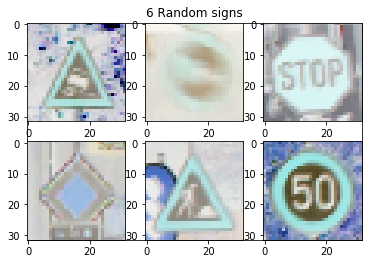

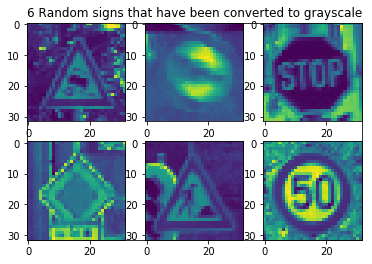

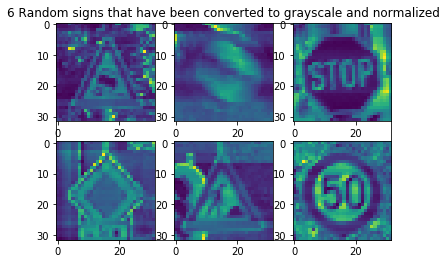

In [17]:
# Small formatting helper function
def make_figure(name, title):
    '''Small helper function to create and format a pyplot figure'''
    figure = plt.figure(name)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    return figure


# Create a figure for each stage in processint and update title/formatting
signs = make_figure("sign", "6 Random signs")

signs_gray = make_figure("sign_gray", "6 Random signs that have been converted to grayscale")
signs_norm = make_figure("sign_norm", "6 Random signs that have been converted to grayscale and normalized")


# Create several plots containing the same random signs at different stages in processing
for i in range(1,7):
    signs.add_subplot(2,3,i)
    signs_gray.add_subplot(2,3,i)
    signs_norm.add_subplot(2,3,i)
    rand_int = random.randint(0,len(features))
    
    # Display 6 random signs from the full dataset
    plt.figure("sign")
    plt.imshow(features[rand_int])
    
    # Display 6 random signs from the full dataset converted to grayscale
    plt.figure("sign_gray")
    plt.imshow(grayscale(features[rand_int]))
    
    # Display 6 random signs from the full dataset converted to grayscale and normalized
    plt.figure("sign_norm")
    plt.imshow(data_normalize(grayscale(features[rand_int])))
plt.show()

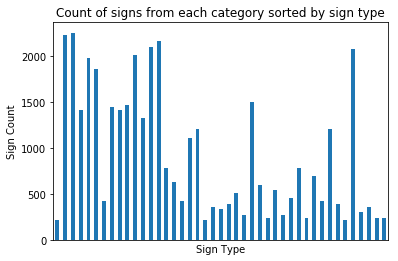

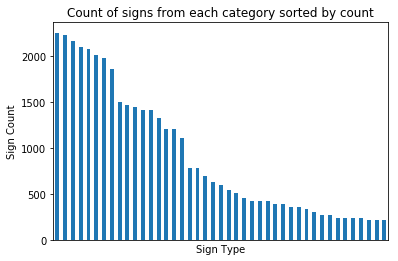

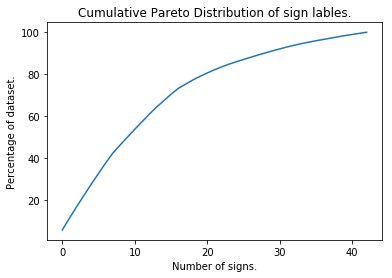

In [18]:
# Small formatting helper function
def make_plot(series, title):
    '''Small helper function to create and format a pyplot figure'''
    figure = plt.figure()
    plt.title(title)
    series.plot(kind="bar")
    plt.ylabel("Sign Count")
    plt.xlabel("Sign Type")
    plt.xticks([])

    
# Plot the frequency of each sign sorted by ID
make_plot(labels_count_sorted, "Count of signs from each category sorted by sign type")

# Plot the frequency of each sign
make_plot(labels_count, "Count of signs from each category sorted by count")

# Calculate and plot a cumulative pareto distribution over the sign counts
plt.figure()
labels_percentage = labels_count / len(labels) * 100 # labels percentage sorted by count
pareto_dist = []
sum = 0.0
for label in labels_percentage:
    sum += label
    pareto_dist.append(sum)
plt.plot(pareto_dist)
plt.title("Cumulative Pareto Distribution of sign lables.")
plt.xlabel("Number of signs.")
plt.ylabel("Percentage of dataset.")

plt.show()

In [19]:
# A detailed list mapping sign names to frequency
for count, sign in zip(labels_count, labels_count.keys()):
    print ("%s with  occurrences %d" %(sign_map[sign], count))

Speed limit (50km/h) with  occurrences 2250
Speed limit (30km/h) with  occurrences 2220
Yield with  occurrences 2160
Priority road with  occurrences 2100
Keep right with  occurrences 2070
No passing for vehicles over 3.5 metric tons with  occurrences 2010
Speed limit (70km/h) with  occurrences 1980
Speed limit (80km/h) with  occurrences 1860
Road work with  occurrences 1500
No passing with  occurrences 1470
Speed limit (100km/h) with  occurrences 1440
Speed limit (120km/h) with  occurrences 1410
Speed limit (60km/h) with  occurrences 1410
Right-of-way at the next intersection with  occurrences 1320
General caution with  occurrences 1200
Ahead only with  occurrences 1200
No entry with  occurrences 1110
Wild animals crossing with  occurrences 780
Stop with  occurrences 780
Turn right ahead with  occurrences 689
No vehicles with  occurrences 630
Traffic signals with  occurrences 600
Children crossing with  occurrences 540
Slippery road with  occurrences 510
Beware of ice/snow with  occurr

An interesting observation that can be seen from the Cumulative Pareto plot is that just over half of the classifiersv(~23/43) make up approximately 80% of the examples.

While this may be some cause for concern, it is very likely that this reflects the real world appearence of such signs (I would guess that Highway Speed limit signs are the most popular and that a 'railroad crossing' sign shows up less frequently). Furthermore, as can be verified by the classifier frequency plots; there are no single classifiers that make up a very small percentage of the dataset.

The classifier that shows up the least frequently shows up just over 200 times, roughly 1/10th of the frequency of the most common sign showing up over 2000 times. This still seems like a rather large occurrence and I do not believe will skew the results of the model much. If the model has problems classifying some of the less frequent signs, it may be worth re-visiting this and possibly manipulating the data such that the less frequent signs are trained more evenly.

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

The first step in my Deep Learning pipeline will be pre-processing. Technically this started back in step 0, when I originally loaded the images and resized them to be a consistent shape.

Taking those resized images, in these steps I will convert the images to grayscale and run them through L2 Normalization.

#### Helper Functions
I first define the preprocess pipeline function. I simply convert the images to grayscale and then normalize them.

In [20]:
def preprocess(X):
    '''Return a Pre-processed X array
    X -> Convert to graysacle -> flatten -> normalize -> reshape(m, h, w, 1)
    '''
    # Save the original shape
    shape = X.shape
    
    # Convert to grayscale
    data = grayscale(X)
    
    # Reshape for L2 Normalization
    data = data.flatten().reshape((shape[0], shape[1] * shape[2]))
    
    # Normalize using Sklearn L2 Normalization
    data = data_normalize(data)

    # Reshape to original size with D=1
    data = data.reshape((shape[0], shape[1], shape[2], 1))
    
    return data

#### Pre-process the X values
I then update the pre-loaded X values with that process.

In [21]:
X_train = preprocess(X_train)
X_cv = preprocess(X_cv)
X_test = preprocess(X_test)

### Define Model Architecture

I started off with the simple LeNet-5 Architecture.

In [22]:
mu = 0
sigma = 0.1

# Define input to be of the img_resize defined earlier, and D=1 for grayscale
x = tf.placeholder(tf.float32, (None, img_resize[0], img_resize[1], 1))

# Convolution 1: Input = 32x32x1. Output = 28x28x6.
# # Initialize Weights ( 5 x 5 kernel ) and Biases ( 6 output channels)
conv_1_W = tf.Variable(tf.truncated_normal((5, 5, 1, 6), mean=sigma, stddev=mu))
conv_1_b = tf.Variable(tf.zeros(6))

# # Create convolution:
conv_1 = tf.nn.conv2d(x, conv_1_W, strides=[1,1,1,1], padding='VALID') + conv_1_b

# # Activate using ReLU
conv_1 = tf.nn.relu(conv_1)

# # Max Pooling: Input = 28x28x6. Output = 14x14x6.
# # # Note: We save this to a new variable so that we can visualize each layer seperately later
conv_1_pool = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID')

# Convolution 2:  Convolutional. Output = 10x10x16
# # Initialize Weights and Biases 
conv_2_W = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean=sigma, stddev=mu))
conv_2_b = tf.Variable(tf.zeros(16))

# # Create convolution:
conv_2 = tf.nn.conv2d(conv_1_pool, conv_2_W, strides=[1,1,1,1], padding='VALID') + conv_2_b

# # Activate using ReLU
conv_2 = tf.nn.relu(conv_2)

# # Pooling. Input = 10x10x16. Output = 5x5x16.
# # # Note: We save this to a new variable so that we can visualize each layer seperately later
conv_2_pool = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# # Flatten
# # # Note: We save this to a new variable so that we can visualize each layer seperately later
conv_2_flat = flatten(conv_2_pool)

# Layer 3: Fully Connected. Input = 400. Output = 120.
# # Initialize Weights and Biases
fc_1_W = tf.Variable(tf.truncated_normal((400,120),mean=sigma, stddev=mu))
fc_1_b = tf.Variable(tf.zeros(120))

# # Create fully connected network
fc_1 = tf.matmul(conv_2_flat, fc_1_W) + fc_1_b

# # Activation.
fc_1 = tf.nn.relu(fc_1)

# Layer 4: Fully Connected. Input = 120. Output = 84.
# # Initialize Weights and Biases
fc_2_W = tf.Variable(tf.truncated_normal((120,84),mean=sigma, stddev=mu))
fc_2_b = tf.Variable(tf.zeros(84))

# # Create fully connected network
fc_2 = tf.matmul(fc_1, fc_2_W) + fc_2_b

# # Activation.
fc_2 = tf.nn.relu(fc_2)

# Layer 5: Fully Connected. Input = 84. Output = 43.
# # Initialize Weights and Biases
fc_3_W = tf.Variable(tf.truncated_normal((84,43),mean=sigma, stddev=mu))
fc_3_b = tf.Variable(tf.zeros(43))

# # Create fully connected network
sign_classification_model = tf.matmul(fc_2, fc_3_W) + fc_3_b

### Train the Model

After defining the model I define some training parameters, some helper training tensors, and then kick off training and save the model to disk.

#### Define Parameters

I found a learning rate of .001 to be satisfactory. Around 4000 Epochs took around 4 hours to run and is where I saw progress stop.

In [23]:
RATE = .001 # Training Learning rate
EPOCHS = 4000  # Training Epoch Count
BATCH_SIZE = 512 # Training Batch Size
RESTORE_FROM_CHECKPOINT = False # When training restore from checkpoint or start fresh
TOP_K = 5 # Number of top probabilities to return during manual results inspection

#### Define Helper Tensorflow Tensors
I define the optimizer to use, the loss_operation to minimize, and I specifically call out the inputs, outputs, and models being used. I also define a few tensors that will be used later to inspect the model.

In [24]:
# Define the input
x = x

# Define outputs to be a one hot encoded array of size n_classes defined earlier
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Model definition
logits = sign_classification_model

# Define cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# Training optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)

# Tensor used during training
training_operation = optimizer.minimize(loss_operation)

# Define tensors for scoring accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define predictors: single best predictor, and top 5 predictor
makeprediction = tf.reduce_max(logits)
top_5_predictions = tf.nn.top_k(tf.nn.softmax(logits), k=TOP_K)

#### Helper Functions
I define a function for evaluation, prediction, and training.

In [25]:
saver = tf.train.Saver()

def get_batches(X, y, offset, batch_size):
    '''Return a batch for X and y. 
    Set y=None to return only x_batch
    Set y=<vals> to return (x_batch, y_batch)
    '''
    X_data = X[offset:offset + batch_size]
    if y is None:
        return X_data
    y_data = y[offset:offset + batch_size]
    return X_data, y_data


def evaluate(X_data, y_data):
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_x, batch_y = get_batches(X_data, y_data, offset, BATCH_SIZE)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / len(X_data)


def predict(X_data):
    '''Take in an X array and return a predictions map.
    predictions["val"] contains the <TOP_K> probabilites.
    predictions["label"] contains the <TOP_K> labels.
    '''
    sess = tf.get_default_session()
    
    # Initialize a dict containing properly shaped numpy arrays to hold IDs, probabilities, and predictions
    predictions = {'val': np.array([]).reshape(0,TOP_K), 
                   'label': np.array([]).reshape(0,TOP_K)}
    
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_x = get_batches(X_data, None, offset, BATCH_SIZE)
        top_k_results = sess.run(top_5_predictions, feed_dict={x: batch_x})
        predictions['val'] = np.vstack((predictions['val'], top_k_results.values))
        predictions['label'] = np.vstack((predictions['label'], top_k_results.indices))
    return predictions 


def single_prediction(prediction):
    '''Take a the output of predict and return the top prediction'''
    return prediction['label'][:, 0]

#### Train the Model

I create a Tensorflow session, restore from checkpoint if specified, and then do the training.

The training will run for the specified number of `EPOCHS` with a static learning rate of `RATE`.

Each epoch will train against all the `X_train` data seperated in random batch of `BATCH_SIZE`.

Increasing the `EPOCH` has generally increased accuracy, Increasing the `BATCH_SIZE` too much has led to a bit of overfitting to the more frequent signs, and making the `RATE` too large or to small led to the usual problems of slowness or local minima (too small) and instability (too big).

In [26]:
with tf.Session() as sess:
    if RESTORE_FROM_CHECKPOINT:
        saver.restore(sess, tf.train.latest_checkpoint('models/'))
    else:
        sess.run(tf.global_variables_initializer())
    start = time()
    print("Training... %s" %(str(start)))
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            batch_x, batch_y = get_batches(X_train, y_train, offset, BATCH_SIZE)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_cv, y_cv)
        print("EPOCH %d ... %s"%(i+1, str(time())))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        saver.save(sess, 'models/lenet')
        print("Model saved")
    print("Took %d minutes to complete"%(int((time()-start)/60)))

Training... 1489550800.438392
EPOCH 1 ... 1489550807.5697773
Validation Accuracy = 0.036
Model saved
EPOCH 2 ... 1489550813.5414155
Validation Accuracy = 0.067
Model saved
EPOCH 3 ... 1489550819.1524086
Validation Accuracy = 0.068
Model saved
EPOCH 4 ... 1489550825.032233
Validation Accuracy = 0.067
Model saved
EPOCH 5 ... 1489550830.9099333
Validation Accuracy = 0.067
Model saved
EPOCH 6 ... 1489550836.525604
Validation Accuracy = 0.066
Model saved
EPOCH 7 ... 1489550842.376266
Validation Accuracy = 0.065
Model saved
EPOCH 8 ... 1489550848.2510176
Validation Accuracy = 0.065
Model saved
EPOCH 9 ... 1489550854.139572
Validation Accuracy = 0.065
Model saved
EPOCH 10 ... 1489550859.7746625
Validation Accuracy = 0.065
Model saved
EPOCH 11 ... 1489550865.6448896
Validation Accuracy = 0.065
Model saved
EPOCH 12 ... 1489550871.5253532
Validation Accuracy = 0.065
Model saved
EPOCH 13 ... 1489550877.1322448
Validation Accuracy = 0.065
Model saved
EPOCH 14 ... 1489550882.9789722
Validation Accu

## Step 3: Test the Model

Now that I have a trained model it is time to see how my results look against the datasets used for training/tuning (X_train and X_cv), the test dataset that my model has not seen directly or indirectly (X_test), and lastly a brand new set of data downloaded from the Internet and in no way related to the original sign dataset.

### Run Against Test Dataset

Here I evaluate against the train, cv, and test dataset.

I expect a high accuracy with the train dataset and a slightly lower accuracy with the cv and test dataset. If the test and cv dataset have a similar and high accuracy it is a good sign that this model will generalize.

A score of 93% is satisfactory for the project; I expect to see an accuracy above 95% with the trained model.

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    test_accuracy = evaluate(X_test, y_test)
    cv_accuracy = evaluate(X_cv, y_cv)
    train_accuracy = evaluate(X_train, y_train)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("CV Accuracy = {:.3f}".format(cv_accuracy))
    print("Train Accuracy = {:.3f}".format(train_accuracy))

Test Accuracy = 0.948
CV Accuracy = 0.955
Train Accuracy = 1.000


#### Dig deeper into the accuracy

As hoped I was able to get the test and cv accuracy to be similar, both around 95%. The training accuracy was 100% which has me a little worried. Either I have a rounding bug somewhere in my evaluation function, I did an incredibly good job modeling, or I have overfit my training data. I tend to think that some overtraining may have occurred here and I would like to go back later and study this further.

Those numbers look good, but let's see which ones we got right and wrong.

I now get the predictions for the X_test dataset and determine how many of each sign was correctly or incorrectly predicted. I consider the highest probability output to be the model's prediction.

In [28]:
# Get predictions for X_test
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    predictions = predict(X_test)
    print("Done getting predictions.")

Done getting predictions.


The most accurate identification was for 2: Speed limit (50km/h) with 224 correct.
The least accurate identification was for 1: Speed limit (30km/h) with 20 incorrect.
The most accurate identification by percentage was for 37: Go straight or left with 1.00%  correct.
The least accurate identification by percentage was for 29: Bicycles crossing with 0.26% incorrect.


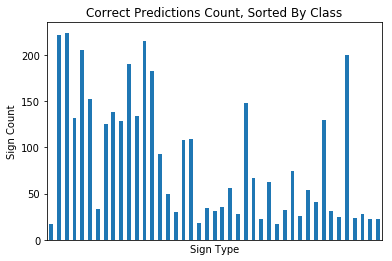

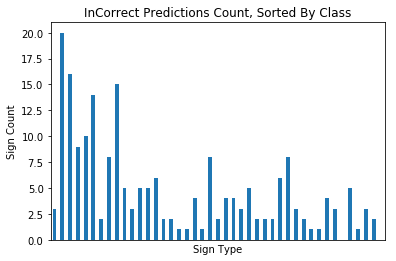

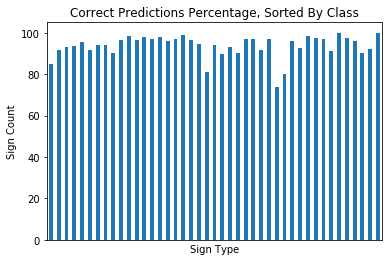

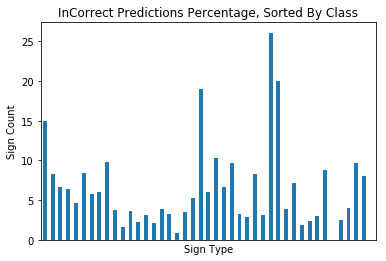

In [99]:
# Create some variables to store a count of how many times we got each label correct or incorrect
correct_test = []
incorrect_test = []

# Create a series containing the count of each label orderd by index
labels_count_test = pd.Series(y_test).value_counts().sort_index()

# Verify all classes showed up in the test set
assert len(labels_count_test) == n_classes

# Used to increase verbosity of printouts
debug = False

# Classes are ints from 0 to n, so we can initalize list indices to correspond with sign labels
for i in range(0,n_classes):
    correct_test.append(0)
    incorrect_test.append(0)

# Update our count variables based on the highest probability prediction
for prediction, label in zip(predictions['label'][:,0], y_test):
    if prediction == label: # Correct prediction
        correct_test[label] += 1
    else: # Incorrect prediction
        incorrect_test[label] += 1

# Iterate over all the signs keeping track of best/worst and printing stats
best = (-1,0)
worst = (-1,0)
best_p = (-1,0)
worst_p = (-1,0)
for label in sign_map.keys():
    if label == -1:
        continue # Skip "unknown" label.
    if debug:
        print("Sign id %d: %s\nCorrect: %d, Incorrect %d" %(label, sign_map[label],
                correct_test[label], incorrect_test[label]))
    if(correct_test[label] + incorrect_test[label] <= 0):
        print("WARNING WARNING WARNING: Sign was never encountered in test set.")
    if worst[1] < incorrect_test[label]:
        worst = (label, incorrect_test[label])
    if best[1] < correct_test[label]:
        best = (label, correct_test[label])
    if worst_p[1] < incorrect_test[label] / labels_count_test[label]:
        worst_p = (label, incorrect_test[label] / labels_count_test[label])
    if best_p[1] < correct_test[label] / labels_count_test[label]:
        best_p = (label, correct_test[label] / labels_count_test[label])
# Plot the count of correct/incorrect
make_plot(pd.Series(correct_test), "Correct Predictions Count, Sorted By Class")
make_plot(pd.Series(incorrect_test), "InCorrect Predictions Count, Sorted By Class")

# Plot the percentages of correct/incorrect
make_plot(pd.Series(correct_test) / labels_count_test * 100, "Correct Predictions Percentage, Sorted By Class")
make_plot(pd.Series(incorrect_test) / labels_count_test * 100, "InCorrect Predictions Percentage, Sorted By Class")

# Print some basic stats
print("The most accurate identification was for %d: %s with %d correct."%(best[0], sign_map[best[0]], best[1]))
print("The least accurate identification was for %d: %s with %d incorrect."%(worst[0], sign_map[worst[0]], worst[1]))
print("The most accurate identification by percentage was for %d: %s with %0.2f%%  correct."%(best_p[0],
        sign_map[best_p[0]], best_p[1]))
print("The least accurate identification by percentage was for %d: %s with %0.2f%% incorrect."%(worst_p[0],
        sign_map[worst_p[0]], worst_p[1]))

# Verify the number of correct + incorrect predictions is the number of actual occurrence
for i in range(0,n_classes):
    assert labels_count_test[i] == correct_test[i] + incorrect_test[i]

### Run Against New Data

To make sure we have not overfit to the style, angle, texture, etc., of the pictures in the train dataset I went and collected data of my own.

This data is in no way related to the original dataset or the authors who collected it. These images were taken from different angles, using different techniques, and different equipment. This is a real-world test, if the model can accurately predict these samples there is a much higher certainty that the model can be generally applied to any German street sign.

#### Finding & Loading New Data

The images were found on various websites from the Internet (who allowed sharing of the images).

I have included the files in this repo in misc_signs.zip. 

The below code will re-use the same feature unpacking, resizing, and preprocessing methods used on the train dataset.

I have included new_features variables for each stage of processing so that I can gain better insight into how those steps function on "real" data.

In [162]:
new_file = os.path.join("datasets", "misc_signs.zip")
new_features, new_labels = uncompress_features_labels(new_file, img_resize)
new_features_original, new_labels = uncompress_features_labels(new_file, None)
new_features_processed = preprocess(new_features)

100%|██████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 276.92files/s]


#### Make Predictions
Now that we have unpacked and processed that data, we are ready to make some predictions.

I start off by printing the `TOP_K` probabilities for each included image. I then give the top prediction for each image along with the correct label, and a few images from processing.

In [163]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    new_predictions_probs = predict(new_features_processed)
    new_predictions = single_prediction(new_predictions_probs)
    print("Done getting predictions.")

Done getting predictions.


In [164]:
print(new_predictions_probs.keys())
for img, label, pred_label, pred_prob in zip(new_features_original,
        new_labels, new_predictions_probs['label'], new_predictions_probs['val']):
    print("\n\nThe model decided an image of a %s had the following probabilities:" %(sign_map[label]))
    for i in range(TOP_K):
        print("%s: %f"%(sign_map[pred_label[i]],pred_prob[i]))

dict_keys(['val', 'label'])


The model decided an image of a dsf had the following probabilities:
Wild animals crossing: 0.996410
General caution: 0.003549
Dangerous curve to the right: 0.000040
No passing for vehicles over 3.5 metric tons: 0.000000
Road work: 0.000000


The model decided an image of a dsf had the following probabilities:
Roundabout mandatory: 1.000000
General caution: 0.000000
Speed limit (100km/h): 0.000000
Speed limit (30km/h): 0.000000
Wild animals crossing: 0.000000


The model decided an image of a dsf had the following probabilities:
Roundabout mandatory: 1.000000
General caution: 0.000000
Speed limit (30km/h): 0.000000
Go straight or left: 0.000000
Speed limit (80km/h): 0.000000


The model decided an image of a dsf had the following probabilities:
No passing for vehicles over 3.5 metric tons: 0.999986
Speed limit (50km/h): 0.000007
Speed limit (100km/h): 0.000007
No passing: 0.000000
Speed limit (80km/h): 0.000000


The model decided an image of a No passing 

I plot each image along with the resized image and pre-processed image. I also include the correct label and prediction with the images.

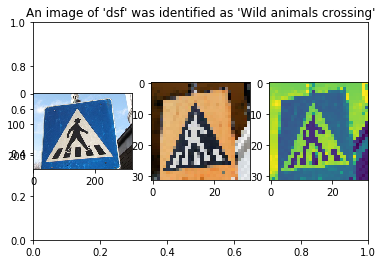

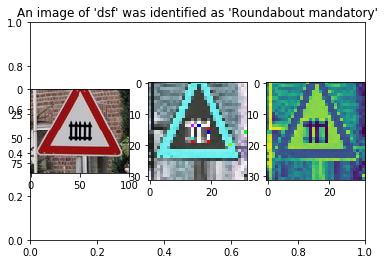

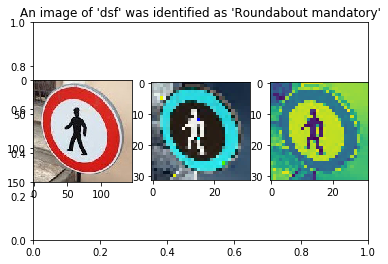

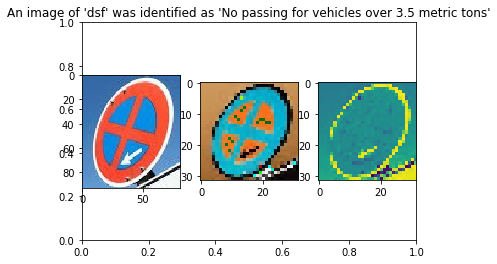

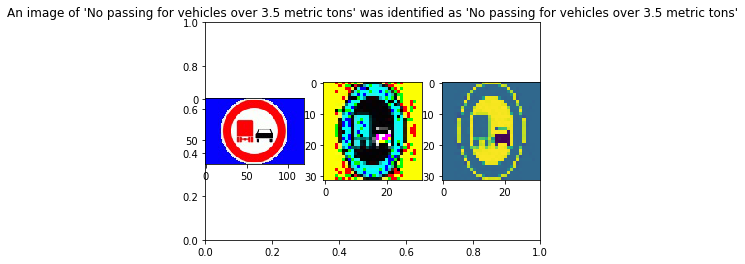

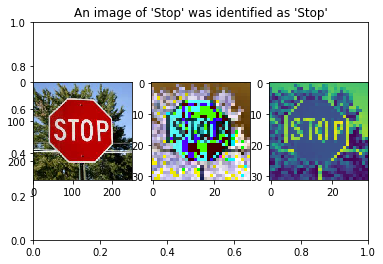

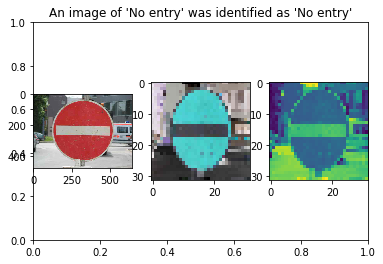

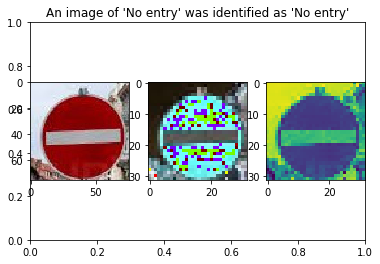

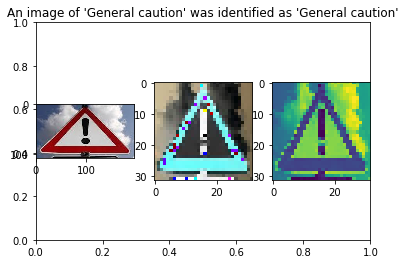

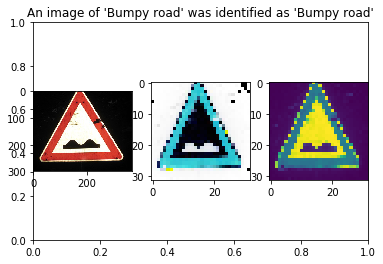

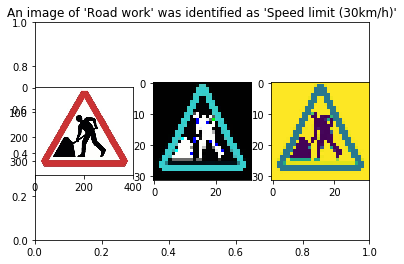

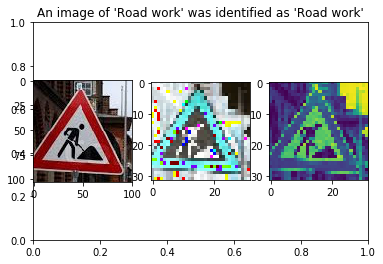

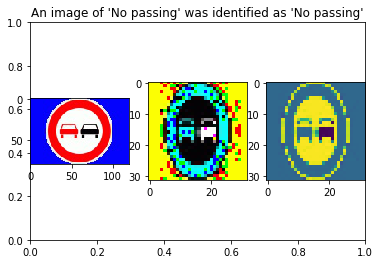

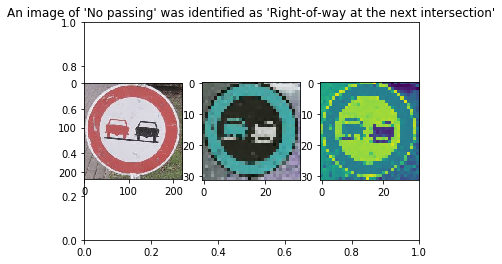

In [165]:
# Open and display the images as-is
for image, image_process, image_orig, label, prediction in zip(new_features,
        new_features_processed, new_features_original, new_labels, new_predictions):
    figure = plt.figure()
    plt.title("An image of '%s' was identified as '%s'" %(sign_map[label], sign_map[prediction]))
    figure.add_subplot(1,3,1)
    plt.imshow(image_orig)
    figure.add_subplot(1,3,2)
    plt.imshow(image)
    figure.add_subplot(1,3,3)
    
    # preprocess expects a 4D array of (m, H, W, 3) and  returns a 4D array of (m, H, W, 1) 
    # So we need to do some manually reshaping for single test images
    plt.imshow(preprocess(image.reshape((1,image.shape[0],image.shape[1],
            image.shape[2]))).reshape(image.shape[0], image.shape[1]))
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

#### Analyze Performance

Lastly, I will run the predictions through my evaulation method to see how accurately we predicted these new images. I omit the images that have classes outside the training set (there is a 100% chance these will be incorrect).

With only a handful of poorly taken pictures it is likely that the accuracy is lower than our test/cv accuracy above. 

In [166]:
# Pull the images with an "unknown" label out before we calculate accuracy.
new_features_processed_acc = [f for f,l in zip(new_features_processed,new_labels) if l != -1]
new_labels_acc = [l for f,l in zip(new_features_processed,new_labels) if l != -1]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('models/'))
    new_accuracy = evaluate(new_features_processed_acc, new_labels_acc)
    print("New Image Accuracy = {:.3f}".format(new_accuracy))

New Image Accuracy = 0.800


For the first two signs I included that were of classes not in the training set we see some odd results. I personally do not know what the first two signs represent, however the model decided they looked similar to the following two images respectively:

![Image of roundabout](http://www.gettingaroundgermany.info/g_imgs/z215.gif)
![Image of no passing trucks](http://www.gettingaroundgermany.info/g_imgs/z277.gif)

I agree with the second guess, but the first one seems rather off to me.

Another interesting find were in the next two images, also of classes not in the training set. I had originally labeled these as 'Pedestrian' and was frustrated with them being mislabeled. After some twiddling and deeper inspection into the dataset I discovered that these were in fact a 'Pedestrian Cross-Walk Ahead' and 'Pedestrians Prohibited', two classes not in the training data. The actual 'Pedestrians' sign in the training data while containing a similar person, is a triangle shape. Given the triangle shape rather than a square/circle I can see that the model did not predict this as a 'Pedestrian' (likely the first convolution determined it could not be a pedestrian given the non-triangle shape).

Originally the 'General Caution' image was much more rectangular and was mis-identified 'Traffic Signals' sign. Comparing the pre-processed image they did appear very similar. I manually cropped a large portion of blue space off the right of the image and it is now identified correctly. This indicates that the model is very sensitive to image size and location of sign in the image. To generalize this a bit more it might be good to expand upon the preprocessing or add a cleaner image_resize/crop pipeline before the data preprocessing (to automate what I did manually). It would also be beneficial to train on a more diverse dataset that did not look so similar.
![Image of signal ahead](http://www.gettingaroundgermany.info/g_imgs/z131.gif)

The model is able to correctly predict a standard road work sign. However when being fed a non-standard road work sign with the working man flipped the model predicts incorrectly (This was a non-german sign). This image also has an unrealistic all white background. This is a good indicator that the model has overfit the training data a bit too much and cannot discern very similar images from a more generalized dataset. So I won't be using the model outside of Germany until we can train on more data.

Similarly the model can predict a no-passing sign, but a no-passign sign that is cropped a bit to heavily is misidentified. Furth proof that the model is highly sensitive to the size/cropping of images.

Overall the model does fairly well on square-like data with a realistic background and does poorly with highly rectangular images on solid white backround. It has odd results on images that are not from the training classes. A last note is that the probabilities tend to be very high or 100% even in the incorrect cases; that indicates that I may have a bug in my model somwhere.


## Step 4: Visualize the Neural Network's State
The Model has been trained, it has been tested, and it works. But what is it doing? Why does it work? What magic happens in the black-box?

I can't know for certain what features the CNN has learned, however I can gain some pretty good insight by inspecting each layer of the network.

In this final step I define a function which runs a stimuli image through a specific step in the trained model. The activation output gives us an idea on what the model is looking for in each layer (edges, groups, points, colors, etc.).

In [167]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    '''
    image_input: the test image being fed into the network to produce the feature maps. Should be an image used during training.
    tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
    activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
    '''

    print("Displaying Feature Maps for %s" %(tf_activation.name))
    sess = tf.get_default_session()

    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3] # The Depth of the 4D activation image
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

In [169]:
def print_feature_maps(num=None):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('models/'))

        # Pick a random image from the training set and resize it to the correct 4D shape
        if num is None:
            num = random.randint(0,len(X_train))
        act_image = X_train[num].reshape((1,img_resize[0], img_resize[1], 1))
        
        # Use the model to predict the image
        stimuli_pred = single_prediction(predict(act_image))

        # Print some information about the image
        print("Displaying image number '%d' of a '%s' sign identified as '%s'."%(num,
                sign_map[y_train[num]], sign_map[stimuli_pred[0]]))
        
        # Pass that image through each convolution stage to see the activations graphically
        outputFeatureMap(act_image, x, activation_min=-1, activation_max=-1 ,plt_num=1)
        outputFeatureMap(act_image, conv_1, activation_min=-1, activation_max=-1 ,plt_num=1)
        outputFeatureMap(act_image, conv_1_pool, activation_min=-1, activation_max=-1 ,plt_num=1)
        outputFeatureMap(act_image, conv_2, activation_min=-1, activation_max=-1 ,plt_num=1)
        outputFeatureMap(act_image, conv_2_pool, activation_min=-1, activation_max=-1 ,plt_num=1)   

Displaying image number '14470' of a 'End of speed limit (80km/h)' sign identified as 'End of speed limit (80km/h)'.
Displaying Feature Maps for Placeholder:0


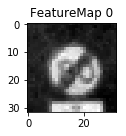

Displaying Feature Maps for Relu:0


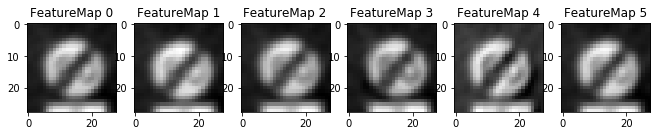

Displaying Feature Maps for MaxPool:0


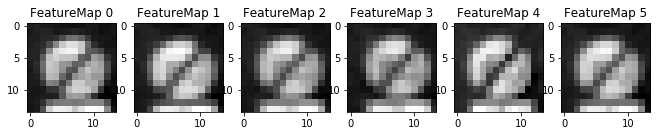

Displaying Feature Maps for Relu_1:0


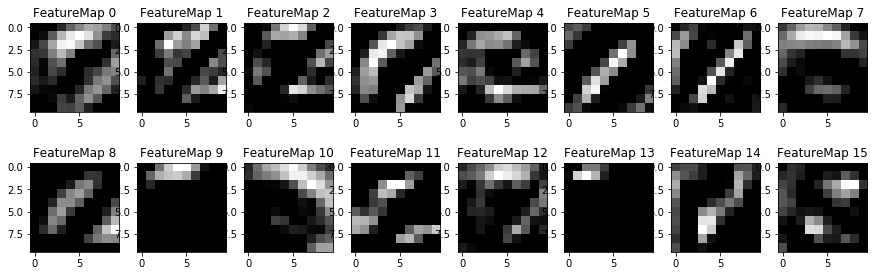

Displaying Feature Maps for MaxPool_1:0


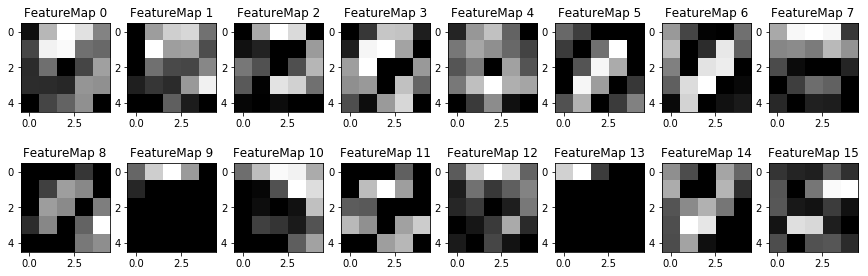

Displaying image number '5972' of a 'Speed limit (100km/h)' sign identified as 'Speed limit (100km/h)'.
Displaying Feature Maps for Placeholder:0


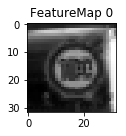

Displaying Feature Maps for Relu:0


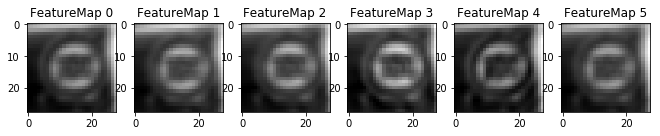

Displaying Feature Maps for MaxPool:0


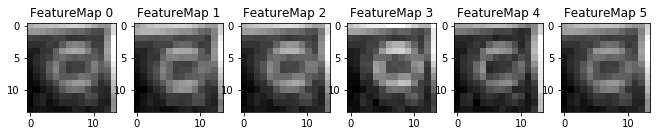

Displaying Feature Maps for Relu_1:0


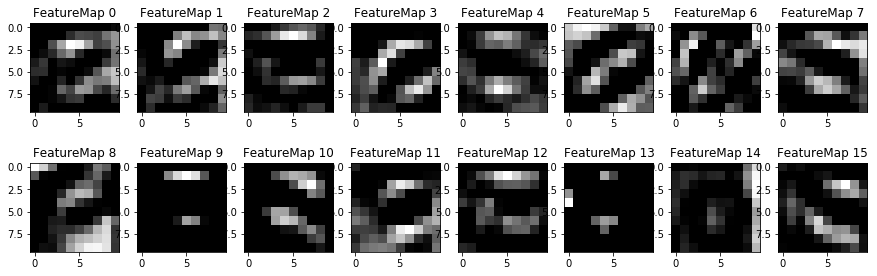

Displaying Feature Maps for MaxPool_1:0


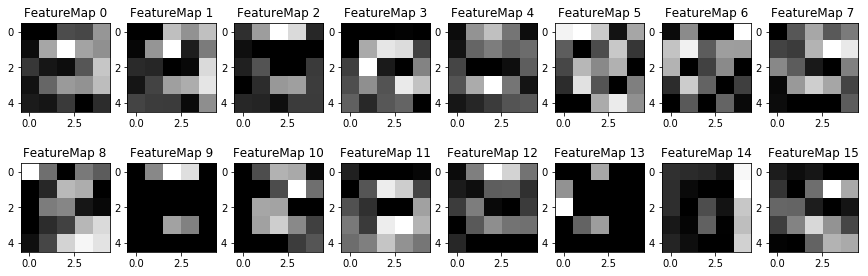

Displaying image number '21967' of a 'Speed limit (50km/h)' sign identified as 'Speed limit (50km/h)'.
Displaying Feature Maps for Placeholder:0


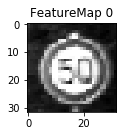

Displaying Feature Maps for Relu:0


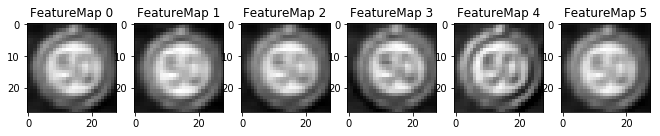

Displaying Feature Maps for MaxPool:0


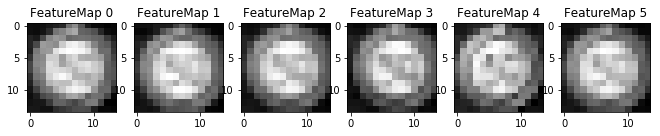

Displaying Feature Maps for Relu_1:0


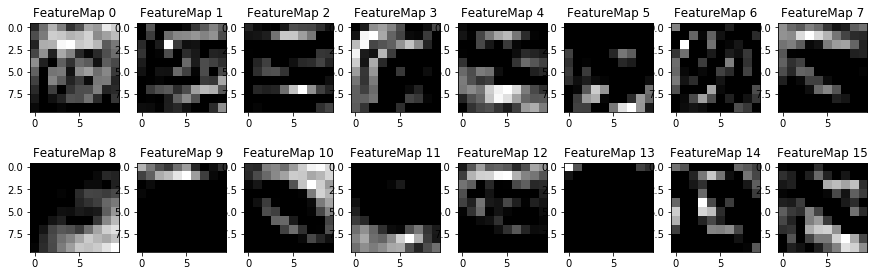

Displaying Feature Maps for MaxPool_1:0


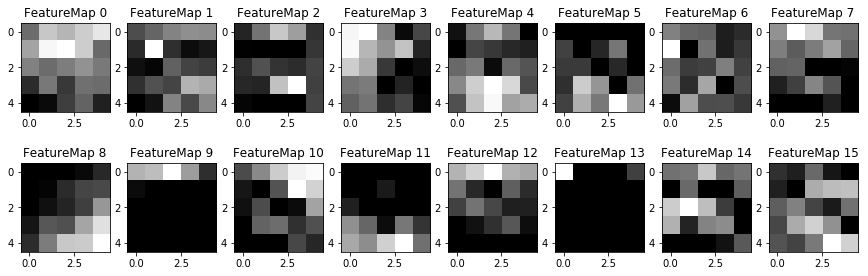

In [171]:
for i in range(0,3):
    print_feature_maps()

#### Feature Map Analysis

It is a little difficult to see at a glance, but upon close inspection of several stimuli images we can see that the first convolutional layer seems to be picking out brightness in different parts of the image. Given that most of the training street signs appear in the center of the image with horizon on the sides, top, and bottom, this makes sense. It seems as though the network has learned a rudimentary method of identifying where the sign is, and possibly the general shape of the sign (rectangle, triangle, circle, etc.).

The second convolutional layer is a bit more mysterious, but it is clear what it is attempting to identify. While the first layer contained a somewhat identifyable image, the second layer is made up of much more blurry and pixelated images. The features seem to map to edges and curves inside and outside the image. This makes sense as a step, most street signs have similar basic shapes (circles, squares, rectangles, triangles) which this step and the previous step seem to be capturing. However what really differentiates street signs is what appears inside the shape (cars, people, words, etc.) which this convolution seems to be capturing (although not clearly).

##### Further Study
The first Maxpooling layer looks very similar to the first activation layer, just a bit noisier. However the second Maxpooling layer looks confusing to the human eye. As further study I would be interested in removing or modifying both or the second pooling layer to see how that affects the results.

It is also interesting that in several of the stimuli images FeatureMap9 and 13 from the second convolution appear completely black. I do not know what this means, but I guess it might have something to do with features only seen in a subset of signs.